# MNIST Convolutional Neural Network - Dataset Expansion
Gaetano Bonofiglio, Veronica Iovinella

The previous experiment gave better results compared to the first one, with a higher accuracy on the test set. 
However we still had lower results compared to the top results on MNIST, with error of 0.21-0.23%, while ours has around 0.55%.

From internal tests, increasing the dropout and reducing the number of epochs did not help (as we will show in this notebook using checkpoints we saved), so out last resort is to use image pre-processing to increase the dataset size and make it more generic applying rotation, scaling and shifts. 
After training on distorted images we'll do some epochs on the normal input to have some bias towards undeformed digits. 
We've also hypothesized that a size of 150 for the hidden layer may have been chosen for computational reasons, so we're going to increase it.  

It's worth mentioning that the authors of [Regularization of Neural Networks using DropConnect](http://cs.nyu.edu/~wanli/dropc/) and [Multi-column Deep Neural Networks for Image Classification](http://people.idsia.ch/~ciresan/data/cvpr2012.pdf) also do ensemble learning with 35 neural networks to increase the precision, while we currently don't. Their best result with a single column is pretty close to our current result.

## Imports

In [1]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [3]:
from keras.datasets import mnist

## Definitions

In [4]:
batch_size = 512
nb_classes = 10
nb_epoch = 800
# checkpoint path
checkpoints_filepath_800 = "checkpoints/02_MNIST_relu_weights.best.hdf5"
checkpoints_filepath_56 = "checkpoints/02_MNIST_relu_weights.best_56_epochs.hdf5"
checkpoints_filepath_new = "checkpoints/03_MNIST_weights.best.hdf5"

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters1 = 20
nb_filters2 = 40
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 150
dense_layer_size1_new = 200
# dropout rate
dropout = 0.15
# activation type
activation = 'relu'

## Data load

In [6]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

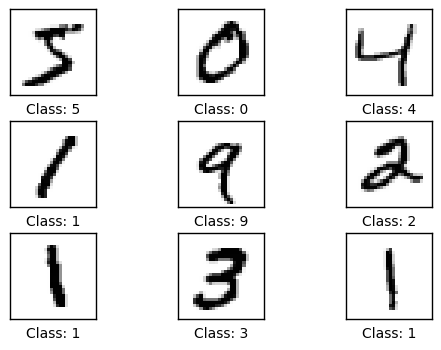

In [7]:
u.plot_images(X_train[0:9], y_train[0:9])

In [8]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Image preprocessing
As said in the introduction, we're going to apply random transformations: rotation with a window of 40 degrees and both vertical and horizontal shifts, zoom and scale with a range of 10% (so about 3 pixels more or 3 pixels less). We avoid flips and rotations that would basically alter the meaning of the symbol.

In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

## Model definition

In [12]:
model_800 = Sequential()
model_56 = Sequential()

model_new = Sequential()

def initialize_network(model, checkpoints_filepath, dropout1=dropout, dropout2=dropout, dense_layer_size1=dense_layer_size1):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall', 'mean_absolute_error'])
    
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    else: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')
    
initialize_network(model_800, checkpoints_filepath_800)
initialize_network(model_56, checkpoints_filepath_56)

initialize_network(model_new, checkpoints_filepath_new, dense_layer_size1_new)

## Training and evaluation
First the evaluations for the network of the previous notebook, with 800 and 56 epochs of training.

In [13]:
# evaluation
print('evaluating 800 epochs model')
score = model_800.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')

print('evaluating 56 epochs model')
score = model_56.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')

evaluating 800 epochs model
Test score: 0.0357797718857
Test accuracy: 0.9944
Test error: 0.550322589874 %
evaluating 56 epochs model
Test score: 0.0291260985197
Test accuracy: 0.9927
Test error: 0.690967769623 %


This part trains the new network (the one using image pre-processing) and then we output the scores. 
We are going to use 800 epochs divided between the pre-processed images and the original ones. 

In [14]:
# checkpoint
checkpoint_new = ModelCheckpoint(checkpoints_filepath_new, monitor='val_precision', verbose=1, save_best_only=True, mode='max')
callbacks_list_new = [checkpoint_new]

# fits the model on batches with real-time data augmentation, for nb_epoch-100 epochs
history_new = model_new.fit_generator(datagen.flow(X_train, Y_train, 
                                                   batch_size=batch_size, 
                                                  # save_to_dir='distorted_data', 
                                                  # save_format='png'
                                                   seed=1337),
                        samples_per_epoch=len(X_train), nb_epoch=nb_epoch-25, verbose=0, 
                        validation_data=(X_test, Y_test), callbacks=callbacks_list_new)

# ensuring best val_precision reached during training
model_new.load_weights(checkpoints_filepath_new)

Epoch 00000: val_precision improved from -inf to 0.94069, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00001: val_precision improved from 0.94069 to 0.95123, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00002: val_precision improved from 0.95123 to 0.96493, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00003: val_precision improved from 0.96493 to 0.97721, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00004: val_precision did not improve
Epoch 00005: val_precision improved from 0.97721 to 0.97780, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00006: val_precision did not improve
Epoch 00007: val_precision improved from 0.97780 to 0.98148, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00008: val_precision improved from 0.98148 to 0.98459, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00009: val_precision did not improve
Epoch 00010: val_precision did not improve
Epoch 00011: val_pr

After epoch 475 nothing will be saved because precision doesn't increase anymore.

In [15]:
# fits the model on clear training set, for nb_epoch-700 epochs
history_new_cont = model_new.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch-775,
                                 verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list_new)

# ensuring best val_precision reached during training
model_new.load_weights(checkpoints_filepath_new)

Epoch 00000: val_precision did not improve
Epoch 00001: val_precision did not improve
Epoch 00002: val_precision did not improve
Epoch 00003: val_precision improved from 0.99489 to 0.99499, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00004: val_precision did not improve
Epoch 00005: val_precision did not improve
Epoch 00006: val_precision improved from 0.99499 to 0.99500, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00007: val_precision did not improve
Epoch 00008: val_precision improved from 0.99500 to 0.99510, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00009: val_precision improved from 0.99510 to 0.99529, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00010: val_precision did not improve
Epoch 00011: val_precision did not improve
Epoch 00012: val_precision did not improve
Epoch 00013: val_precision improved from 0.99529 to 0.99559, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00014: val_precision did no

In [16]:
print('evaluating new model')
score = model_new.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')

evaluating new model
Test score: 0.0158230795545
Test accuracy: 0.9952
Test error: 0.440322589874 %


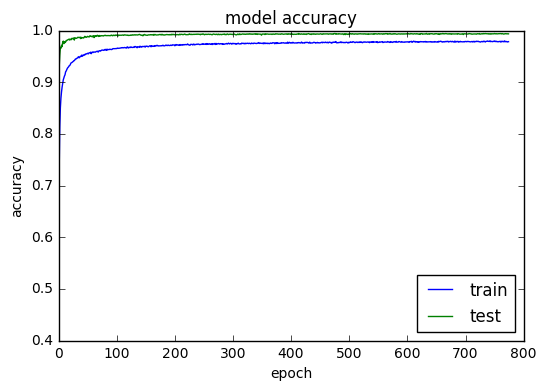

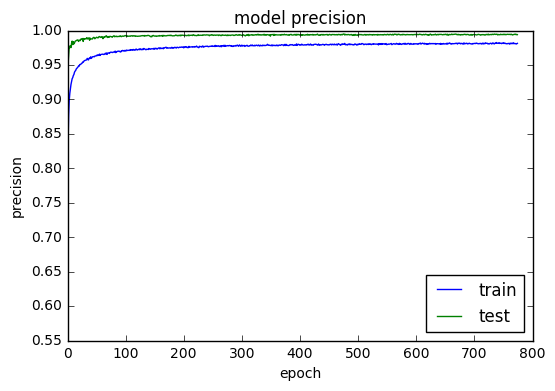

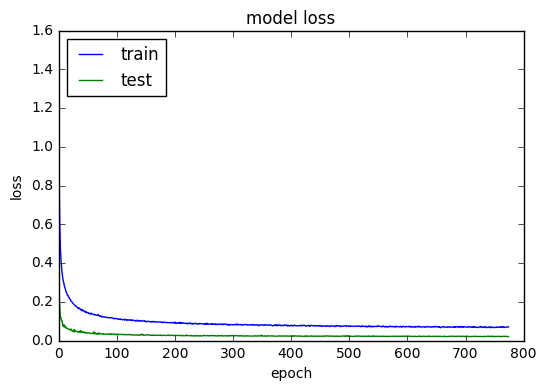

Continuation of training with no pre-processing


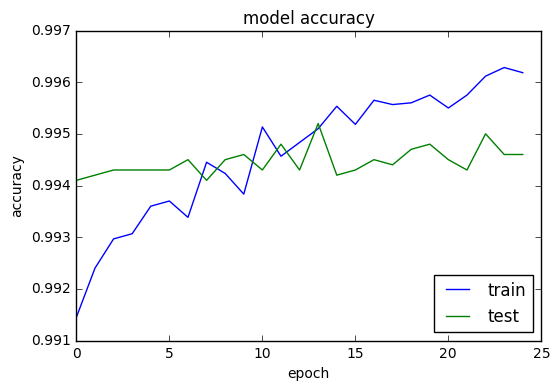

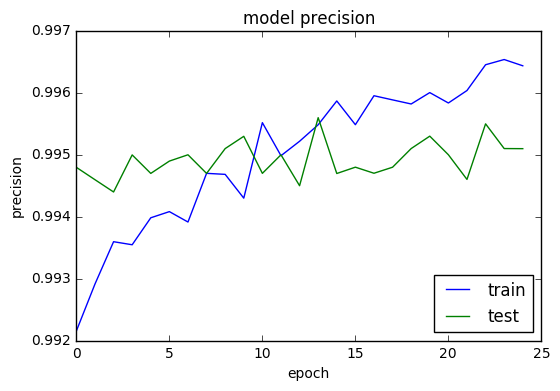

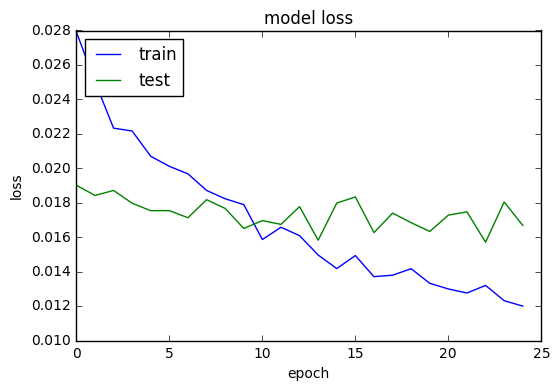

In [17]:
u.plot_history(history_new)
u.plot_history(history_new, 'precision')
u.plot_history(history_new, metric='loss', loc='upper left')
print("Continuation of training with no pre-processing")
u.plot_history(history_new_cont)
u.plot_history(history_new_cont, 'precision')
u.plot_history(history_new_cont, metric='loss', loc='upper left')

Overall the method seems to work, with the precision converging to 99.4% in the first part of the training, and reaching 99.55% in the second part. 

The epochs that make the model overfit and lose val_precision are cut away by the callback function that saves the model. 

## Inspecting the result
Results marked with "800" are relative to the network of notebook 02 after 800 epochs, while the ones marked with "56" are for the same network but after 56 epochs. 

Results marked with "new" are relative to the network that uses image pre-processing and has a fully connected layer size of 250.

In [18]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes_800 = model_800.predict_classes(X_test)
predicted_classes_56 = model_56.predict_classes(X_test)
predicted_classes_new = model_new.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices_800 = np.nonzero(predicted_classes_800 == y_test)[0]
incorrect_indices_800 = np.nonzero(predicted_classes_800 != y_test)[0]

correct_indices_56 = np.nonzero(predicted_classes_56 == y_test)[0]
incorrect_indices_56 = np.nonzero(predicted_classes_56 != y_test)[0]

correct_indices_new = np.nonzero(predicted_classes_new == y_test)[0]
incorrect_indices_new = np.nonzero(predicted_classes_new != y_test)[0]

 9856/10000 [============================>.] - ETA: 0s

### Examples of correct predictions (800)

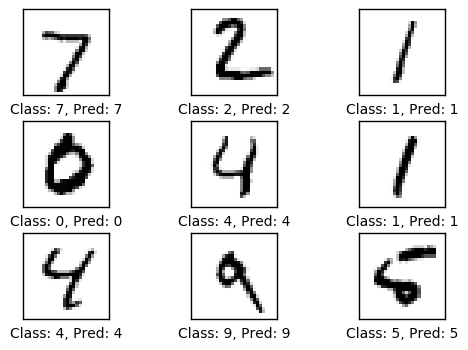

In [19]:
u.plot_images(X_test[correct_indices_800[:9]], y_test[correct_indices_800[:9]], 
              predicted_classes_800[correct_indices_800[:9]])

### Examples of incorrect predictions (800)

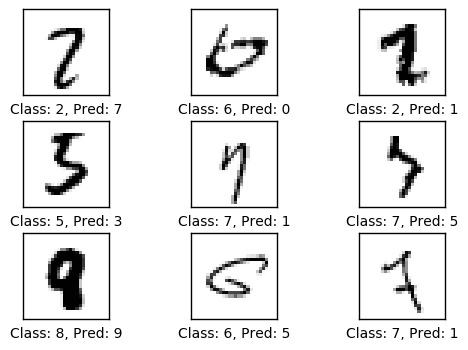

In [20]:
u.plot_images(X_test[incorrect_indices_800[:9]], y_test[incorrect_indices_800[:9]], 
              predicted_classes_800[incorrect_indices_800[:9]])

### Examples of correct predictions (56)

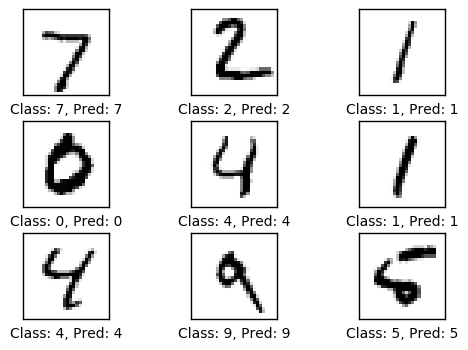

In [21]:
u.plot_images(X_test[correct_indices_56[:9]], y_test[correct_indices_56[:9]], 
              predicted_classes_56[correct_indices_56[:9]])

### Examples of incorrect predictions (56)

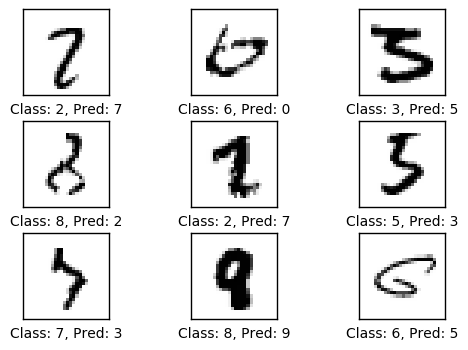

In [22]:
u.plot_images(X_test[incorrect_indices_56[:9]], y_test[incorrect_indices_56[:9]], 
              predicted_classes_56[incorrect_indices_56[:9]])

### Examples of correct predictions (new)

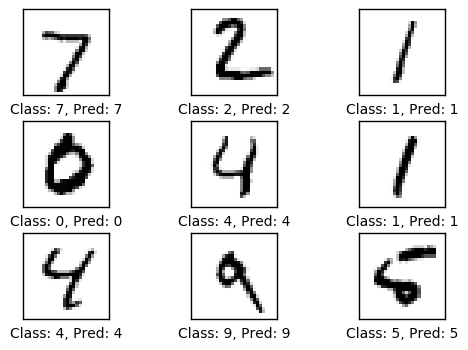

In [23]:
u.plot_images(X_test[correct_indices_new[:9]], y_test[correct_indices_new[:9]], 
              predicted_classes_new[correct_indices_new[:9]])

### Examples of incorrect predictions (new)

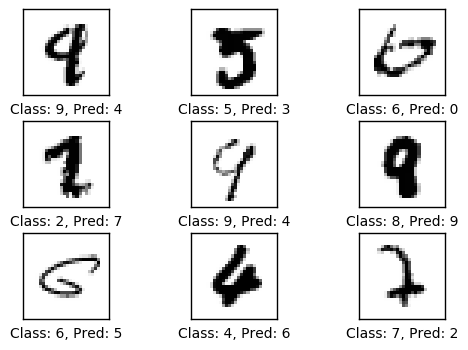

In [24]:
u.plot_images(X_test[incorrect_indices_new[:9]], y_test[incorrect_indices_new[:9]], 
              predicted_classes_new[incorrect_indices_new[:9]])

### Confusion matrix (800)

[[ 975    1    0    0    0    0    1    2    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    1 1024    2    0    0    0    4    0    0]
 [   0    0    0 1009    0    0    0    1    0    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   1    0    0    5    0  884    1    1    0    0]
 [   3    2    0    0    1    1  949    0    2    0]
 [   1    4    2    0    0    1    0 1019    1    0]
 [   0    0    0    0    1    0    0    1  971    1]
 [   1    0    0    0    7    1    0    2    1  997]]


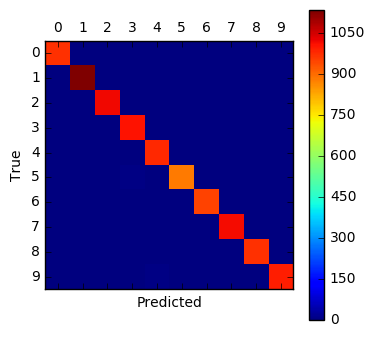

In [25]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_800)

### Confusion matrix (56)

[[ 974    1    1    0    0    0    1    2    1    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    0 1024    2    0    0    0    5    0    0]
 [   0    0    1 1006    0    3    0    0    0    0]
 [   0    0    0    0  979    0    0    0    1    2]
 [   1    0    0    6    0  881    1    1    2    0]
 [   2    1    0    0    1    3  950    0    1    0]
 [   0    4    5    2    0    0    0 1017    0    0]
 [   1    0    2    1    0    0    0    1  968    1]
 [   1    0    0    0    5    1    0    3    4  995]]


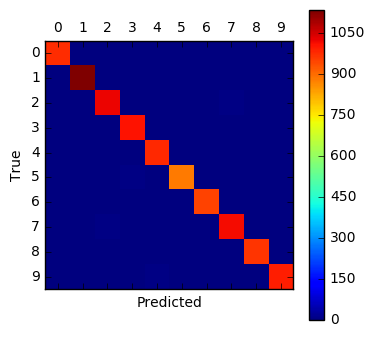

In [26]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_56)

### Confusion matrix (56)

[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   1    0 1026    1    0    0    0    4    0    0]
 [   0    0    2 1006    0    1    0    1    0    0]
 [   0    0    0    0  978    0    1    0    0    3]
 [   0    0    0    3    0  885    2    1    0    1]
 [   2    2    1    0    0    3  949    0    1    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   0    0    1    0    0    1    0    0  970    2]
 [   0    0    0    0    7    0    0    0    0 1002]]


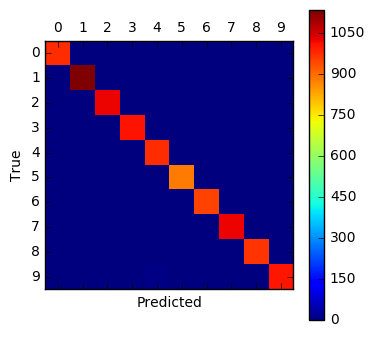

In [27]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_new)

## Results
The time required to perform epoch with image distortions was significantly higher, with about 20 seconds for each epoch on our average GPU that was previously able to compute one epoch in 6 seconds for the same network (without distortions). However the error (calculated as 1-precision) decreased from 0.55% to about 0.45% after the same number of epochs. Increasing the size of the dense layer from 150 to 200 gave us a small boost in precision, reaching 0.44% error, but increased the time required to perform the same number of epochs by 5 seconds each. 

Without using MCDNN this is a very good result, considering that a single network from the MCDNN paper could only reach 0.52% error. The papers we mentioned in the introduction use ensemble learning on multiple networks (35) to achieve 0.23% error.

It is still unclear if we can use the same pre-processing for the datasets of In Codice Ratio, because characters to classify should be regular as the ones of the training dataset. Also the time required to train this network may not be worth the increase of precision, compared to the one that achieves 0.6% error after just 56 epochs. We are talking about 3 hours of training to improve by 0.15% precision compared to just 4 minutes. 

An hybrid approach we tested internally consists in doing 175 epochs with pre-processing and then 25 more without pre-processing. Overall it gives nice performances (between 0.55% and 0.6% error) but takes less then an hour to train.